In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV

from tqdm import tqdm
from joblib import delayed, Parallel

import logging
import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from learning.utils.load_experiment import LoadExperiment
from learning.policy_pricer import policy_pricer_python
# from learning.policy_pricer.cython_pricer import cython_pricer_optimized

In [15]:
model = tf.keras.Sequential(
    [tf.keras.layers.Input(2),
        tf.keras.layers.Dense(2, activation="relu", name="layer1"),
        tf.keras.layers.Dense(3, activation="relu", name="layer2"),
        tf.keras.layers.Dense(4, name="layer3"),
    ])
model.compile()
model.build()

In [19]:
model.get_weights()

[array([[0.2993616 , 0.44085145],
        [0.15053082, 0.49083948]], dtype=float32),
 array([0., 0.], dtype=float32),
 array([[ 0.7339076 , -0.0062716 , -0.8654771 ],
        [ 0.30417454, -0.57115334, -0.00641894]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[ 0.7809769 , -0.5547936 , -0.8602128 , -0.53274745],
        [ 0.20697618, -0.55593365, -0.25371414,  0.7567903 ],
        [-0.90234077, -0.4762143 , -0.06983942,  0.26410866]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32)]

In [3]:
ldr = LoadExperiment(backup=False)
agents = os.listdir(os.path.join(ldr.repo, 'models'))
print(agents[-7])
cps = ldr.list_checkpoints(agents[-1], -1)
ag = ldr.load_agent_from_path(cps[5])

DQNL2comp-1
[WARNING] [2021-04-22 14:04:50,726] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [4]:
oav = OAV(ag.env.params, 200, nx=300, ny=200, lmax=17)
oav.solve_v()

[INFO] [2021-04-22 14:04:50,755] [AAV] - Instantiated @ AAV
[INFO] [2021-04-22 14:04:50,768] [OAV] - Launching the value function procedure.
[INFO] [2021-04-22 14:04:50,769] [OAV] - Computing the value function on (0.00, 21.10].
[INFO] [2021-04-22 14:04:50,974] [OAV] - Computing the value function on (21.10, 23.45].
[INFO] [2021-04-22 14:05:14,435] [OAV] - Computing the value function on (23.45, 26.05].
[INFO] [2021-04-22 14:05:24,311] [OAV] - Computing the value function on (26.05, 28.95].
[INFO] [2021-04-22 14:05:36,466] [OAV] - Computing the value function on (28.95, 32.16].
[INFO] [2021-04-22 14:05:47,434] [OAV] - Computing the value function on (32.16, 35.73].
[INFO] [2021-04-22 14:05:58,265] [OAV] - Computing the value function on (35.73, 39.71].
[INFO] [2021-04-22 14:06:11,211] [OAV] - Computing the value function on (39.71, 44.12].
[INFO] [2021-04-22 14:06:23,835] [OAV] - Computing the value function on (44.12, 49.02].
[INFO] [2021-04-22 14:06:40,830] [OAV] - Computing the valu

[WARNING] [2021-04-22 14:27:14,223] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-04-22 14:27:14,393] [tensorflow] - AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x0000022B91AC8288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


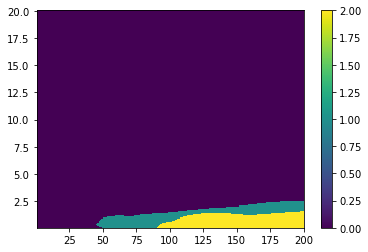

In [9]:
ag = ldr.load_agent_from_path(cps[-1])
ww, ll, p, z = policy_pricer_python.create_map(ag, larger_offset=True, w_points = 300, l_points=200, lam_lim=20)

plt.pcolormesh(ww, ll, p, shading='auto')
plt.colorbar()
plt.show()

In [10]:
aav = AAV(Parameters())

[INFO] [2021-04-22 14:27:17,307] [AAV] - Instantiated @ AAV


In [13]:
l = np.linspace(ag.env.observation_space.low[0], 20, 200)
w = np.linspace(ag.env.observation_space.low[1], ag.env.observation_space.high[1], 300)
ww1, ll1, u = aav.evaluate_aav(l, w)

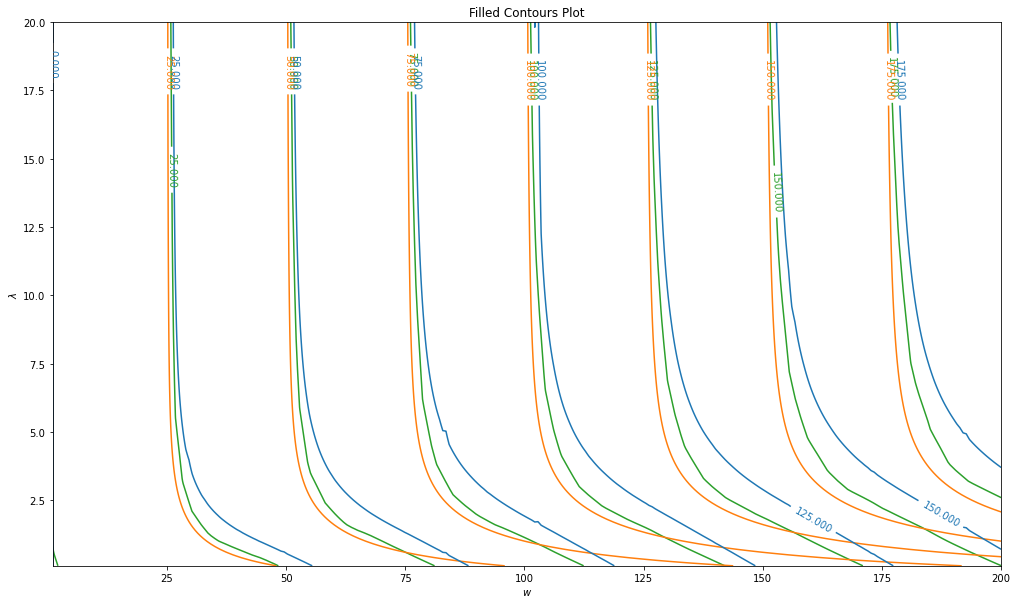

In [14]:
fig,ax=plt.subplots( figsize=(17, 10))
cp1 = ax.contour(ww, ll, z, colors='C2')
cp0 = ax.contour(ww, ll, -u, colors='C1')
cp2 = ax.contour(ww, ll, -oav.zz, colors='C0')

ax.clabel(cp1, inline=True, fontsize=10)
ax.clabel(cp0, inline=True, fontsize=10)
ax.clabel(cp2, inline=True, fontsize=10)


# fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_ylabel(r'$\lambda$')
ax.set_xlabel(r'$w$')
plt.show()

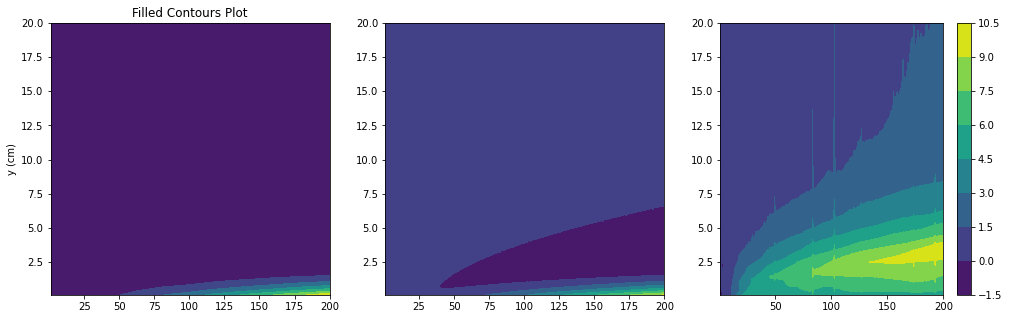

In [17]:
fig,ax=plt.subplots(ncols=3, figsize=(17,5))
cp = ax[0].contourf(ww, ll, z + u)
cp = ax[1].contourf(ww, ll, + u - oav.zz)
cp = ax[2].contourf(ww, ll, z + oav.zz)
fig.colorbar(cp) # Add a colorbar to a plot
ax[0].set_title('Filled Contours Plot')
ax[0].set_ylabel('y (cm)')
plt.show()